In [1]:
import numpy as np
import sympy as sp
import sys
sys.path.append("../src/")

from MiyamotoNagaiPotential import *
from matplotlib import pyplot as plt

# 1. Contruct transformation

## set up Hamiltonian object 

This sets up a `celmech.Hamiltonian` object representing the Hamiltonian of a particle in a Miyamoto-Nagai potential. This object will be used below to calculate derivatives of the effective potential and to directly integrate orbits.

In [2]:
L,a,b = 3,3,0.3

Rc = MiyamotoNagai_L_to_Rc(L,a,b)
vc = L/Rc
ham = MiyamotoNagai_get_hamiltonian([Rc,0,0,0],L,a,b)

`ham` stores a symbolic representation of the Hamiltonian

In [3]:
ham.H

  2       2      2                                  
 L     p_R    p_z                   1               
──── + ──── + ──── - ───────────────────────────────
   2    2      2          __________________________
2⋅R                      ╱                        2 
                        ╱       ⎛       _________⎞  
                       ╱    2   ⎜      ╱  2    2 ⎟  
                     ╲╱    R  + ⎝a + ╲╱  b  + z  ⎠  

## Compute values of $H_n$
Now we'll use `sympy` along with some utility functions to develop a series representation of the Hamiltonian in terms of the complex variables $x_R$ and $x_z$ and their complex conjugates.

In [4]:
from celmech.poisson_series import PoissonSeries
from SeriesUtils import PotentialDerivativesToPoissonSeries
from SeriesUtils import pert_series_to_PoissonSeries

In [5]:
R,z,pR,pz = ham.qp_vars
qp_rule = ham.qp
cvar_symbols = sp.symbols("x_R,x_z,xbar_R,xbar_z")

In [6]:
lmax = 8 # max order to carry out expansion
derivs = dict()
for n in range(2,lmax+1):
    for l in range(n+1):
        nR = n-l
        nz = l
        derivs[(nR,nz)]=float(sp.diff(ham.N_H,R,nR,z,nz).xreplace(qp_rule))        
ham_series = PotentialDerivativesToPoissonSeries(derivs,lmax,cvar_symbols=cvar_symbols)

As an example, $H_5$, the terms appearing at order $5$ in the variables $(x_R,x_z,\bar{x}_R,\bar{x}_z)$ when expanding the Hamiltonian about a circular and planar orbit, is given as an expression:

In [7]:
ham_series[5].as_expression()

                         5                          4                             3    2                         3                                 
- 0.00184766149112621⋅x_R  - 0.00923830745563106⋅x_R ⋅x̅_R - 0.0090494661750377⋅x_R ⋅x_z  - 0.0180989323500754⋅x_R ⋅x_z⋅x̅_z - 0.0184766149112621⋅x

3    2                         3    2                         2    2                             2                                     2    3      
_R ⋅x̅_R  - 0.0090494661750377⋅x_R ⋅x̅_z  - 0.0271483985251131⋅x_R ⋅x_z ⋅x̅_R - 0.0542967970502262⋅x_R ⋅x_z⋅x̅_R⋅x̅_z - 0.0184766149112621⋅x_R ⋅x̅_

                   2        2                            4                          3                                 2    2                       
R  - 0.0271483985251131⋅x_R ⋅x̅_R⋅x̅_z  + 0.345656716399051⋅x_R⋅x_z  + 1.3826268655962⋅x_R⋅x_z ⋅x̅_z - 0.0271483985251131⋅x_R⋅x_z ⋅x̅_R  + 2.073940

    2    2                                 2                                  3                              

## compute $\chi$ and $H'$
The `celmech` function `poisson_series.birkhoff_normalize` carries out the Birkhoff normalization process up to a user-specified order.

In [8]:
from celmech.poisson_series import birkhoff_normalize

In [9]:
omega = np.array((ham_series[2][(1,0,1,0)],ham_series[2][(0,1,0,1)]))
omega = np.real(omega)
omega

array([0.03134891, 0.09209087])

In [10]:
chi, ham1_series = birkhoff_normalize(omega,ham_series,lmax)

In [11]:
chi,ham1_series

(defaultdict(<function celmech.poisson_series.birkhoff_normalize.<locals>.<listcomp>.<lambda>()>,
             {3: <celmech.poisson_series.PoissonSeries at 0x7fbb87ee0bd0>,
              4: <celmech.poisson_series.PoissonSeries at 0x7fbb87e96f50>,
              5: <celmech.poisson_series.PoissonSeries at 0x7fbb880a7010>,
              6: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03c90>,
              7: <celmech.poisson_series.PoissonSeries at 0x7fbb87afda10>,
              8: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03210>}),
 defaultdict(<function celmech.poisson_series.birkhoff_normalize.<locals>.<listcomp>.<lambda>()>,
             {2: <celmech.poisson_series.PoissonSeries at 0x7fbb87afefd0>,
              3: <celmech.poisson_series.PoissonSeries at 0x7fbb87cc6350>,
              4: <celmech.poisson_series.PoissonSeries at 0x7fbb880fb050>,
              5: <celmech.poisson_series.PoissonSeries at 0x7fbb88245690>,
              6: <celmech.poisson_series.PoissonSeri

# 2. Compute $(x,v)\rightarrow (J,\theta)$
Construct series for 
$$
x'_i = \exp[-\mathcal{L}_\chi]x_i
$$

In [12]:
from celmech.poisson_series import expLinv
from SeriesUtils import get_xseries, to_pade1_approx_function, to_pade2_approx_function
from celmech.poisson_series import PSTerm

Series representations of $x_R$ and $x_z$

In [13]:
xR_series, xz_series = get_xseries(2)
xR_series[1].as_expression(),xz_series[1].as_expression()

(1.0⋅z₁, 1.0⋅z₂)

Series representations of $x_R'$ and $x_z'$ are polynomials of degree $l_\mathrm{max}-1$. `expLinv` returns these as dictionaries with terms grouped by order.

In [14]:
xR_prime_series = expLinv(xR_series,chi)
xz_prime_series = expLinv(xz_series,chi)
xR_prime_series,xz_prime_series

(defaultdict(<function celmech.poisson_series.birkhoff_normalize.<locals>.<listcomp>.<lambda>()>,
             {1: <celmech.poisson_series.PoissonSeries at 0x7fbb87b02b10>,
              2: <celmech.poisson_series.PoissonSeries at 0x7fbb882c7350>,
              3: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03890>,
              4: <celmech.poisson_series.PoissonSeries at 0x7fbb88245210>,
              5: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03090>,
              6: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03250>,
              7: <celmech.poisson_series.PoissonSeries at 0x7fbb87b28f50>}),
 defaultdict(<function celmech.poisson_series.birkhoff_normalize.<locals>.<listcomp>.<lambda>()>,
             {1: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03b10>,
              2: <celmech.poisson_series.PoissonSeries at 0x7fbb88259250>,
              3: <celmech.poisson_series.PoissonSeries at 0x7fbb87b03850>,
              4: <celmech.poisson_series.PoissonSeri

We convert these grouped dictionaries to regular `PoissonSeries` objects with the `pert_series_to_PoissonSeries` function

In [15]:
xR_osc_to_mean = pert_series_to_PoissonSeries(xR_prime_series)
xz_osc_to_mean = pert_series_to_PoissonSeries(xz_prime_series)

In [16]:
xR_exprn = xR_osc_to_mean.as_expression()
xz_exprn = xz_osc_to_mean.as_expression()
_xR_f = sp.lambdify(xR_osc_to_mean.cvar_symbols,xR_exprn)
_xz_f = sp.lambdify(xz_osc_to_mean.cvar_symbols,xz_exprn)

xR_osc_to_mean_function = lambda xR,xz: _xR_f(xR,xz,np.conjugate(xR),np.conjugate(xz))
xz_osc_to_mean_function = lambda xR,xz: _xz_f(xR,xz,np.conjugate(xR),np.conjugate(xz))

Consruct (1,n) and (2,n-1) Pade approximants for $x_R'$ by grouping terms in powers of $I_z$ using the functions `to_pade1_approx_function` and `to_pade2_approx_function` defined in `SeriesUtils`

In [17]:
_xR_func = to_pade1_approx_function(xR_osc_to_mean)
xR_osc_to_mean_pade1 = lambda xR,xz: _xR_func(xR,np.conjugate(xR),np.abs(xz)**2,xz/np.abs(xz))

_xR_func2 = to_pade2_approx_function(xR_osc_to_mean)
xR_osc_to_mean_pade2 = lambda xR,xz: _xR_func2(xR,np.conjugate(xR),np.abs(xz)**2,xz/np.abs(xz))

Consruct (1,n) and (2,n-1) Pade approximants for the polynmoial $P$ in $x_z' =x_z P(x_R,x_z,\bar{x}_R,\bar{x}_z)$ by grouping terms in powers of $I_z$.

In [18]:
newterms = [PSTerm(term.C,term.k-np.array((0,1)),term.kbar,term.p,term.q) for term in xz_osc_to_mean.terms]
xz_osc_to_mean_by_xz = PoissonSeries.from_PSTerms(newterms)

_xz_func = to_pade1_approx_function(xz_osc_to_mean_by_xz)
xz_osc_to_mean_pade1 = lambda xR,xz: xz * _xz_func(xR,np.conjugate(xR),np.abs(xz)**2,xz/np.abs(xz))

_xz_func2 = to_pade2_approx_function(xz_osc_to_mean_by_xz)
xz_osc_to_mean_pade2 = lambda xR,xz: xz * _xz_func2(xR,np.conjugate(xR),np.abs(xz)**2,xz/np.abs(xz))

## Integrate an orbit

Integration loop

In [19]:
R0,z0,pR0,pz0 = Rc, 0., 0.15 * vc , 0.05 * vc
x0 = [R0,z0,pR0,pz0]
ham.state.t = 0.
ham.state.values = x0
Nout = 4*128
orbit = np.zeros((Nout,ham.N_dim))
times = np.linspace(0,5,Nout) * 2*np.pi/np.min(omega)
for i,t in enumerate(times):
    ham.integrate(t)
    orbit[i] = ham.state.values

Compute actions

In [20]:
xR_values = np.sqrt(0.5*omega[0]) * ((orbit.T[0]-Rc) + 1j * orbit.T[2]/omega[0])
xz_values = np.sqrt(0.5*omega[1]) * ((orbit.T[1]) + 1j * orbit.T[3]/omega[1])

xR_prime_values_taylor = xR_osc_to_mean_function(xR_values,xz_values)
xz_prime_values_taylor = xz_osc_to_mean_function(xR_values,xz_values)

xR_prime_values_pade1 = xR_osc_to_mean_pade1(xR_values,xz_values)
xz_prime_values_pade1 = xz_osc_to_mean_pade1(xR_values,xz_values)

xR_prime_values_pade2 = xR_osc_to_mean_pade2(xR_values,xz_values)
xz_prime_values_pade2 = xz_osc_to_mean_pade2(xR_values,xz_values)

IR_values = np.abs(xR_values)**2
Iz_values = np.abs(xz_values)**2

JR_values_taylor = np.abs(xR_prime_values_taylor)**2
Jz_values_taylor = np.abs(xz_prime_values_taylor)**2

JR_values_pade1 = np.abs(xR_prime_values_pade1)**2
Jz_values_pade1 = np.abs(xz_prime_values_pade1)**2

JR_values_pade2 = np.abs(xR_prime_values_pade2)**2
Jz_values_pade2 = np.abs(xz_prime_values_pade2)**2

Plot

Text(0, 0.5, '$\\Delta J_z / J_Z$')

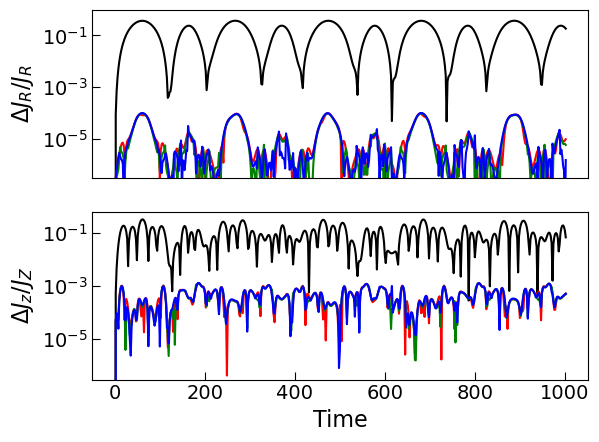

In [21]:
fig,ax = plt.subplots(2,1,sharex=True)


for i,J in enumerate([IR_values,JR_values_taylor,JR_values_pade1,JR_values_pade2]):
    ax[0].plot(times,np.abs(J/J[0]-1),color='krgb'[i])
for i,J in enumerate([Iz_values,Jz_values_taylor,Jz_values_pade1,Jz_values_pade2]):
    ax[1].plot(times,np.abs(J/J[0]-1),color='krgb'[i])

for a in ax:
    plt.sca(a)
    plt.yscale('log')
    plt.ylim(ymin=3e-7)
    plt.tick_params(labelsize = 14,direction='in',size=6)
    plt.tick_params(which='minor',direction='in',size=4)
ax[1].set_xlabel("Time",fontsize=16)
ax[0].set_ylabel(r"$\Delta J_R / J_R$",fontsize=16)
ax[1].set_ylabel(r"$\Delta J_z / J_Z$",fontsize=16)



# 3. Predict orbit using $(J,\theta)\rightarrow (x,v)$
Here we'll construct the explicit transformation from AA variables to Cartesian data in order to predict analytically the numerically integrated orbit found above. The inverse transformation will use the fact that 
$$
x_i(x'_R,x'_z,\bar{x}'_R,\bar{x}'_z)=(\exp[\mathcal{L}_\chi]x'_i)(x'_R,x'_z,\bar{x}'_R,\bar{x}'_z)~.
$$
We'll use the `celmech` function `poisson_series.expL` to get a series approximation of the r.h.s. of this equation.

In [22]:
from SeriesUtils import h_series_to_omega_series
from celmech.poisson_series import expL

In [23]:
xR_series,xz_series = get_xseries(2)
xR_of_xprime = expL(xR_series,chi)
xz_of_xprime = expL(xz_series,chi)
xR_of_xprime,xz_of_xprime

(defaultdict(<function celmech.poisson_series.birkhoff_normalize.<locals>.<listcomp>.<lambda>()>,
             {1: <celmech.poisson_series.PoissonSeries at 0x7fbb87352ed0>,
              2: <celmech.poisson_series.PoissonSeries at 0x7fbb87bb5a90>,
              3: <celmech.poisson_series.PoissonSeries at 0x7fbb87180490>,
              4: <celmech.poisson_series.PoissonSeries at 0x7fbb87107810>,
              5: <celmech.poisson_series.PoissonSeries at 0x7fbb8725a410>,
              6: <celmech.poisson_series.PoissonSeries at 0x7fbb8729c590>,
              7: <celmech.poisson_series.PoissonSeries at 0x7fbb8735b190>}),
 defaultdict(<function celmech.poisson_series.birkhoff_normalize.<locals>.<listcomp>.<lambda>()>,
             {1: <celmech.poisson_series.PoissonSeries at 0x7fbb87104090>,
              2: <celmech.poisson_series.PoissonSeries at 0x7fbb87e95b10>,
              3: <celmech.poisson_series.PoissonSeries at 0x7fbb872b1290>,
              4: <celmech.poisson_series.PoissonSeri

As above, we'll convert each of these dictionaries, the entries of which hold terms of a given order, into a single `PoissonSeries` object. These series will allow us to go from "mean" variables to osculating ones.

In [24]:
xR_mean_to_osc = pert_series_to_PoissonSeries(xR_of_xprime)
xz_mean_to_osc = pert_series_to_PoissonSeries(xz_of_xprime)

We turn our series into functions with `sympy.lambdify`

In [25]:
xR_exprn = xR_mean_to_osc.as_expression()
xz_exprn = xz_mean_to_osc.as_expression()

_xR_f = sp.lambdify(xR_mean_to_osc.cvar_symbols,xR_exprn)
_xz_f = sp.lambdify(xz_mean_to_osc.cvar_symbols,xz_exprn)

xR_mean_to_osc_function = lambda xR,xz: _xR_f(xR,xz,np.conjugate(xR),np.conjugate(xz))
xz_mean_to_osc_function = lambda xR,xz: _xz_f(xR,xz,np.conjugate(xR),np.conjugate(xz))

The Hamiltonian, $H'(J_R,J_z)$ is used to get $\Omega_R(J_R,J_z)$ and $\Omega_z(J_R,J_z)$ using the `h_series_to_omega_series` function.

In [26]:
ham1 = pert_series_to_PoissonSeries(ham1_series)
Omega_R_series,Omega_z_series = h_series_to_omega_series(ham1)

In [27]:
NOmega_R = np.real(Omega_R_series([xR_prime_values_taylor[0],xz_prime_values_taylor[0]],[],[]))
NOmega_z = np.real(Omega_z_series([xR_prime_values_taylor[0],xz_prime_values_taylor[0]],[],[]))

Predicted orbit according to the epicyclic approximation

In [28]:
xR_predicted_epi = xR_values[0] * np.exp(- 1j * omega[0] * times)
xz_predicted_epi = xz_values[0] * np.exp(- 1j * omega[1] * times)

Predict orbit using
$$x_i\left(x'_{R,0}e^{-i\Omega_R t} ,x'_{z,0}e^{-i\Omega_zt} ,\bar{x}'_{R,0}e^{i\Omega_Rt} ,\bar{x}'_{z,0}e^{i\Omega_zt} \right)$$

In [29]:
xR_predicted_taylor = xR_mean_to_osc_function(
    xR_prime_values_taylor[0] * np.exp(- 1j * NOmega_R * times),
    xz_prime_values_taylor[0] * np.exp(- 1j * NOmega_z * times)
)
xz_predicted_taylor = xz_mean_to_osc_function(
    xR_prime_values_taylor[0] * np.exp(- 1j * NOmega_R * times),
    xz_prime_values_taylor[0] * np.exp(- 1j * NOmega_z * times)
)

Plot orbits

Text(0.5, 0, 'Time')

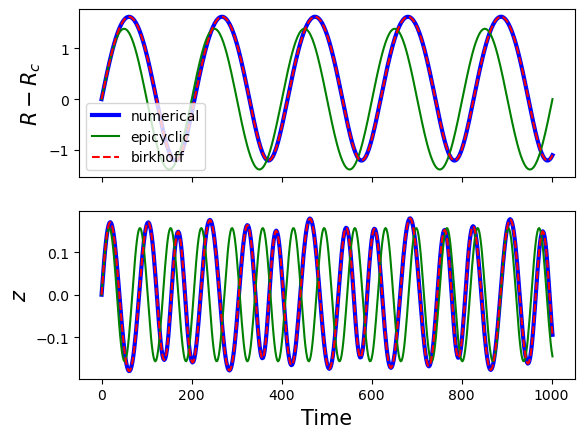

In [30]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(times, orbit.T[0]-Rc,'b-',lw=3,label='numerical')
ax[0].plot(times, np.real(xR_predicted_epi)* np.sqrt(2/omega[0]),'g-',label='epicyclic')
ax[0].plot(times, np.real(xR_predicted_taylor)* np.sqrt(2/omega[0]),'r--',label='birkhoff')
ax[0].set_ylabel("$R-R_c$",fontsize=15)
ax[0].legend(loc='lower left')

ax[1].plot(times, orbit.T[1],'b-',lw=3)
ax[1].plot(times, np.real(xz_predicted_epi) * np.sqrt(2/omega[1]),'g-')
ax[1].plot(times, np.real(xz_predicted_taylor)* np.sqrt(2/omega[1]),'r--')
ax[1].set_ylabel("$z$",fontsize=15)
ax[1].set_xlabel("Time",fontsize=15)